In [297]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt  
%matplotlib inline        
import seaborn as sns
import plotly.graph_objects as go

#models
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

#evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

!pip install xgboost
#from xgboost.xgbclassifier import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [249]:
#read dataset
preprocessed_df = pd.read_csv('./Data/preprocessed_df.cvs', index_col = 0) 
preprocessed_df.head()

,status_group,amount_tsh,gps_height,longitude,latitude,population,age,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,...,scheme_name_group_machumba estate pipe line,scheme_name_group_makwale water supplied sche,scheme_name_group_mkongoro one,scheme_name_group_mtwango water supply scheme,scheme_name_group_n,scheme_name_group_ngana water supplied scheme,scheme_name_group_other,scheme_name_group_s,scheme_name_group_uroki-bomang'ombe water sup,scheme_name_group_wanging'ombe water
0,0,6000.0,1390,34.938093,-9.856322,109,14,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0.0,1399,34.698766,-2.147466,280,3,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,25.0,686,37.460664,-3.821329,250,4,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0.0,263,38.486161,-11.155298,58,27,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0.0,0,31.130847,-1.825359,150,17,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [250]:
preprocessed_df.shape

(59400, 287)

In [251]:
#define X and y
y = preprocessed_df['status_group']
X = preprocessed_df.drop(['status_group'], axis = 1)

In [252]:
from sklearn.model_selection import train_test_split

#perform test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

After splitting the data into training and test sets, we use the `MixMaxScaler()` to fit and transform `X_train` and transform `X_test` of continuous variables.

We want to fit and transform only the training data because in a real-world setting, we only have access to this data. We can then use the same scalar object to transform the test data. 

If we to first transform the data and then split into training and test sets, it will lead to data-leakage. 

In [253]:
from sklearn.preprocessing import MinMaxScaler

#scale to make sure that all of our data is represented at the same scale
scale = MinMaxScaler()

#fit
X_train_scaled = scale.fit_transform(X_train) #to create a scaled version of the training dataset
X_test_scaled = scale.transform(X_test) #to create a scaled version of the test dataset

# Initial Model (without correcting class imbalance)

In [254]:
from sklearn.linear_model import LogisticRegression

#instantiate the model
logreg = LogisticRegression(fit_intercept = False, C = 1e12, solver = 'liblinear')

#fit the model
logreg.fit(X_train_scaled, y_train)

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [255]:
#generate predictions
y_hat_train = logreg.predict(X_train_scaled)
y_hat_test = logreg.predict(X_test_scaled)

### Evaluate

In [264]:
#accuracy 
accuracy = accuracy_score(y_test, y_hat_test) * 100
print('Accuracy is :{0}'.format(acc))

Accuracy is :75.95959595959596


In [256]:
from sklearn.model_selection import cross_val_score

#evaluate with cross validation
logreg_cv_score = cross_val_score(logreg, X_train_scaled, y_train, cv = 3)
print('Cross Validation Score:', logreg_cv_score)

Cross Validation Score: [0.75296717 0.74646465 0.7459596 ]


In [257]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

#evaluate with MAE, MSE, RMSE
print('Mean Absolute Error:', mean_absolute_error(y_test, y_hat_test))  
print('Mean Squared Error:', mean_squared_error(y_test, y_hat_test))  
print('Root Mean Squared Error:', mean_squared_error(y_test, y_hat_test, squared = False))

Mean Absolute Error: 0.3021885521885522
Mean Squared Error: 0.4079124579124579
Root Mean Squared Error: 0.6386802470035048


In [267]:
#classification report
logreg_classification_report = classification_report(y_test, y_hat_test)
print('Model: Logistic Regression', '\n', logreg_classification_report)

Model: Logistic Regression 
               precision    recall  f1-score   support

           0       0.73      0.89      0.81      6434
           1       0.79      0.67      0.73      4614
           2       0.52      0.11      0.18       832

    accuracy                           0.75     11880
   macro avg       0.68      0.56      0.57     11880
weighted avg       0.74      0.75      0.73     11880



In [262]:
from sklearn.metrics import confusion_matrix

#confusion matrix
confusion_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix:\n', confusion_matrix)

Confusion Matrix:
 [[5744  649   41]
 [1488 3086   40]
 [ 587  157   88]]


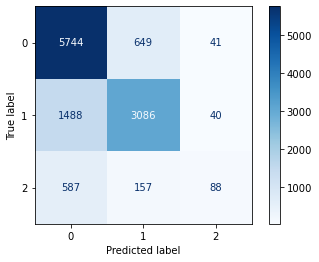

In [263]:
#visualize confusion_matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(logreg, X_test_scaled, y_test, cmap = plt.cm.Blues)

# K-Nearest Neighbor

In [169]:
from sklearn.neighbors import KNeighborsClassifier

#instantiate KNeighborsClassifier
classifier = KNeighborsClassifier()

#fit
classifier.fit(X_train_scaled, y_train)

#predict on the test set
y_hat_test = classifier.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

#evaluate
print('Mean Absolute Error:', mean_absolute_error(y_test, y_hat_test))  
print('Mean Squared Error:', mean_squared_error(y_test, y_hat_test))  
print('Root Mean Squared Error:', mean_squared_error(y_test, y_hat_test, squared = False))

In [170]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    
print_metrics(y_test, y_hat_test)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

# Decision Tree

In [190]:
from sklearn.tree import DecisionTreeClassifier

#instantiate
classifier = DecisionTreeClassifier(random_state = 21, criterion = 'entropy')

#fit
classifier.fit(X_train_scaled, y_train)

#predict
y_hat_test = classifier.predict(X_test_scaled)

In [191]:
#feature importance
classifier.feature_importances_

array([2.41797925e-02, 7.11259087e-02, 1.74765454e-01, 1.55491491e-01,
       4.89285073e-02, 4.97500954e-02, 1.74997332e-03, 1.68705836e-03,
       1.00627388e-03, 4.98341201e-04, 5.42947081e-04, 1.26713944e-03,
       4.96367904e-04, 4.77954828e-04, 1.09072056e-04, 2.62400306e-03,
       5.54785721e-04, 0.00000000e+00, 0.00000000e+00, 1.06852767e-04,
       4.21570431e-04, 4.08411992e-04, 1.36066478e-04, 3.29272920e-05,
       3.35769899e-04, 5.29362514e-04, 1.59447365e-04, 3.99788478e-04,
       2.63008524e-04, 0.00000000e+00, 7.57119919e-04, 5.11630709e-05,
       5.25590108e-04, 8.58009606e-04, 5.34263833e-05, 2.25488469e-03,
       0.00000000e+00, 2.44366127e-03, 2.55894431e-04, 1.46470423e-04,
       0.00000000e+00, 2.21538691e-03, 1.64143534e-03, 7.84283033e-04,
       1.76681088e-04, 8.86246743e-04, 9.17318418e-05, 1.88549416e-05,
       3.29272920e-05, 1.40690128e-04, 0.00000000e+00, 7.33380042e-04,
       1.84905406e-04, 1.78402760e-04, 1.22975948e-04, 1.75135016e-04,
      

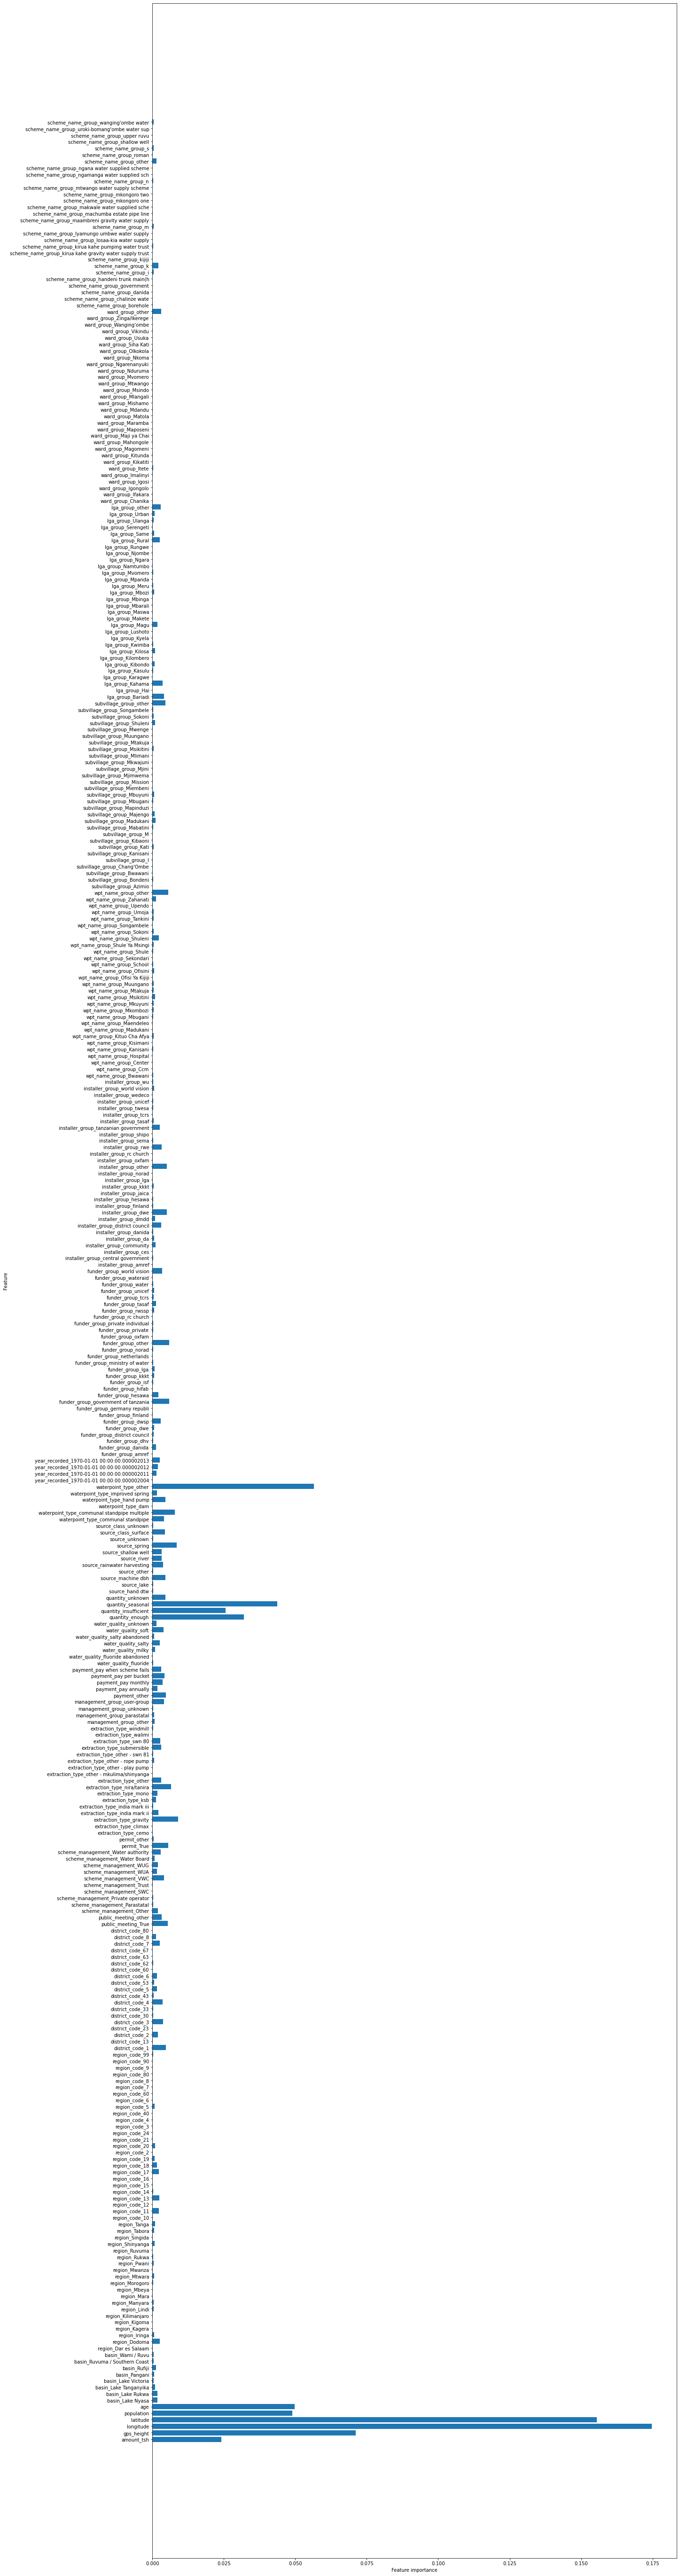

In [202]:
def plot_feature_importances(model):
    n_features = X_train_scaled.shape[1]
    plt.figure(figsize = (20, 100))
    plt.barh(range(n_features), model.feature_importances_, align = 'center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(classifier)

#save
plt.savefig('./Data/feature_importances')

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

#evaluate
print('Mean Absolute Error:', mean_absolute_error(y_test, y_hat_test))  
print('Mean Squared Error:', mean_squared_error(y_test, y_hat_test))  
print('Root Mean Squared Error:', mean_squared_error(y_test, y_hat_test, squared = False))

In [182]:
#identify the optimal tree depth for given data
max_depths = np.linspace(1, 32, 32, endpoint = True)
train_results = []
test_results = []

for max_depth in max_depths:
    dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = max_depth, random_state = 21)
    dt.fit(X_train_scaled, y_train)
    
    y_hat_train = dt.predict(X_train_scaled)
    false_positive_rate, true_positive_rate, threshholds = roc_curve(y_train, y_hat_train)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    #add auc score to previous train results
    train_results.append(roc_auc)
    y_hat_test = dt.predict(X_test_scaled)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_hat_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    #add auc score to previous test results
    test_results.append(roc_auc)
    
plt.figure(figsize = (15, 5))
plt.plot(max_depths, train_results, 'b', label = 'Train AUC')
plt.plot(max_depths, test_results, 'r', label = 'Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()

ValueError: multiclass format is not supported

In [ ]:
#identify the optimal min-samples-split for given data
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []

for min_samples_split in min_samples_splits:
    classifier = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = min_samples_split, random_state = 21)
    classifier.fit(X_train_scaled, y_train)
    
    y_hat_train = classifier.predict(X_train_scaled)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_hat_train)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred = classifier.predict(X_test_scaled)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_hat_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

plt.figure(figsize = (15, 5))
plt.plot(min_samples_splits, train_results, 'b', label = 'Train AUC')
plt.plot(min_samples_splits, test_results, 'r', label = 'Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Min. Sample splits')
plt.legend()
plt.show()

In [ ]:
#calculate the optimal value for minimum sample leafs
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []

for min_samples_leaf in min_samples_leafs:
    classifier = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf = min_samples_leaf, random_state = 21)
    classifier.fit(X_train_scaled, y_train)
    
    y_hat_train = classifier.predict(X_train_scaled)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_hat_train)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_hat_test = classifier.predict(X_test_scaled)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_hat_test
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
plt.figure(figsize = (15, 5))    
plt.plot(min_samples_leafs, train_results, 'b', label = 'Train AUC')
plt.plot(min_samples_leafs, test_results, 'r', label = 'Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Min. Sample Leafs')
plt.legend()
plt.show()

In [ ]:
#find the best value for optimal maximum feature size
max_features = list(range(1, X_train.shape[1]))
train_results = []
test_results = []

for max_feature in max_features:
    dt = DecisionTreeClassifier(criterion = 'entropy', max_features = max_feature, random_state = 21)
    dt.fit(X_train_scaled, y_train)
    
    y_hat_train = dt.predict(X_train_scaled)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_hat_train)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_hat_test = dt.predict(X_test_scaled)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_hat_test)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

plt.figure(figsize = (12, 6))
plt.plot(max_features, train_results, 'b', label = 'Train AUC')
plt.plot(max_features, test_results, 'r', label = 'Test AUC')
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.legend()
plt.show()

In [ ]:
#train a classifier with optimal values identified above
classifier = DecisionTreeClassifier(criterion = 'entropy',
                           max_features = 6,
                           max_depth = 3,
                           min_samples_split = 0.7,
                           min_samples_leaf = 0.25,
                           random_state = SEED)

#fit
classifier.fit(X_train_scaled, y_train)

#predict
y_hat_test = dt.predict(X_test_scaled)

In [ ]:
#calculate accuracy 
accuracy = accuracy_score(y_test, y_hat_test) * 100
print('Accuracy is :{0}'.format(acc))

In [ ]:
#check the AUC for predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_hat_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))

In [ ]:
#create and print a confusion matrix 
print('\nConfusion Matrix')
print('----------------')
pd.crosstab(y_test, y_hat_test, rownames = ['True'], colnames = ['Predicted'], margins = True)

In [ ]:
#plot
plot_confusion_matrix(classifier, X, y, cmap = plt.cm.Blues)

In [ ]:
from sklearn import tree

#plot and show decision tree
#plt.figure(figsize = (15, 15), dpi = 500)
#tree.plot_tree(classifier_2, 
               #feature_names = X.columns,
               #class_names = np.unique(y).astype('str'),
               #filled = True, rounded = True)
#plt.show()

# CART Regressor

In [245]:
from sklearn.tree import DecisionTreeRegressor

#instantiate 
dt_regressor_classifier = DecisionTreeRegressor(random_state = 21)

#fit
dt_regressor_classifier.fit(X_train_scaled, y_train)

#predict
y_hat_test = regressor.predict(X_test_scaled)

In [246]:
#accuracy
accuracy = dt_regressor_classifier.score(X_train_scaled, y_train)
accuracy

0.9901978427977132

In [247]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

#evaluate
print('Mean Absolute Error:', mean_absolute_error(y_test, y_hat_test))  
print('Mean Squared Error:', mean_squared_error(y_test, y_hat_test))  
print('Root Mean Squared Error:', mean_squared_error(y_test, y_hat_test, squared = False))

Mean Absolute Error: 0.3139061286377266
Mean Squared Error: 0.44588590066059086
Root Mean Squared Error: 0.6677468836771842


In [248]:
#classification report
dt_regressor_classification_report = classification_report(y_test, y_hat_test)
print('Model: Decision Tree Regressor', '\n', dt_regressor_classification_report)

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

# Bagged Tree

In [273]:
from sklearn.ensemble import BaggingClassifier

#instantiate a BaggingClassifier
bagged_tree_clf = BaggingClassifier(DecisionTreeClassifier(criterion = 'gini', max_depth = 5), n_estimators = 20)

#fit
bagged_tree_clf.fit(X_train_scaled, y_train)

#predict
y_hat_test = bagged_tree_clf.predict(X_test_scaled)

In [274]:
#accuracy
accuracy = bagged_tree_clf.score(X_train_scaled, y_train)
accuracy

0.719570707070707

In [275]:
#evaluate with cross validation
print('Cross Validation Score:', cross_val_score(bagged_tree_clf, X, y, cv = 5).mean())

Cross Validation Score: 0.7177441077441078


In [276]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

#evaluate
print('Mean Absolute Error:', mean_absolute_error(y_test, y_hat_test))  
print('Mean Squared Error:', mean_squared_error(y_test, y_hat_test))  
print('Root Mean Squared Error:', mean_squared_error(y_test, y_hat_test, squared = False))

Mean Absolute Error: 0.3398989898989899
Mean Squared Error: 0.4607744107744108
Root Mean Squared Error: 0.6788036614326788


In [277]:
#classification report
bagged_tree_classification_report = classification_report(y_test, y_hat_test)
print('Model: Bagged Tree', '\n', bagged_tree_classification_report)

Model: Bagged Tree 
               precision    recall  f1-score   support

           0       0.68      0.94      0.79      6434
           1       0.84      0.54      0.66      4614
           2       0.61      0.04      0.08       832

    accuracy                           0.72     11880
   macro avg       0.71      0.51      0.51     11880
weighted avg       0.74      0.72      0.69     11880



In [278]:
#confusion matrix
bagged_tree_confusion_matrix = confusion_matrix(y_test, y_hat_test)
print(random_forest_confusion_matrix)

#plot
plot_confusion_matrix(bagged_tree_clf, X_test_scaled, y_test, cmap = plt.cm.Blues)

TypeError: 'numpy.ndarray' object is not callable

# Random Forest

In [279]:
from sklearn.ensemble import RandomForestClassifier

#instantiate
random_forest_clf = RandomForestClassifier(n_estimators = 100, max_depth = 5)

#fit
random_forest_clf.fit(X_train_scaled, y_train)

#predict
y_hat_test = random_forest_clf.predict(X_test_scaled)

In [280]:
#accuracy
accuracy = random_forest_clf.score(X_train_scaled, y_train)
accuracy

0.6782617845117845

In [281]:
#evaluate with cross validation
print('Cross Validation Score:', cross_val_score(random_forest_clf, X, y, cv = 5).mean())

Cross Validation Score: 0.6761447811447812


In [282]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

#evaluate
print('Mean Absolute Error:', mean_absolute_error(y_test, y_hat_test))  
print('Mean Squared Error:', mean_squared_error(y_test, y_hat_test))  
print('Root Mean Squared Error:', mean_squared_error(y_test, y_hat_test, squared = False))

Mean Absolute Error: 0.38855218855218854
Mean Squared Error: 0.5164983164983165
Root Mean Squared Error: 0.7186781731055399


In [283]:
#classification report
random_forest_classification_report = classification_report(y_test, y_hat_test)
print('Model: Random Forest', '\n', random_forest_classification_report)

Model: Random Forest 
               precision    recall  f1-score   support

           0       0.64      0.96      0.77      6434
           1       0.85      0.40      0.54      4614
           2       0.00      0.00      0.00       832

    accuracy                           0.68     11880
   macro avg       0.49      0.45      0.44     11880
weighted avg       0.67      0.68      0.63     11880



In [284]:
#confusion matrix
random_forest_confusion_matrix = confusion_matrix(y_test, y_hat_test)
print(random_forest_confusion_matrix)

#plot
plot_confusion_matrix(random_forest_clf, X_test_scaled, y_test, cmap = plt.cm.Blues)

TypeError: 'numpy.ndarray' object is not callable

# Grid Search CV

# Gradient Boosting

In [268]:
from sklearn.ensemble import GradientBoostingClassifier

#instantiate
gradient_boost_clf = GradientBoostingClassifier(random_state = 21)

#fit
gradient_boost_clf.fit(X_train_scaled, y_train)

#predict
y_hat_test = gradient_boost_clf.predict(X_test_scaled)

In [269]:
#accuracy
accuracy = gradient_boost_clf.score(X_train_scaled, y_train)
accuracy

0.7604377104377105

In [ ]:
#evaluate with cross validation
print('Cross Validation Score:', cross_val_score(gradient_boost_clf, X, y, cv = 5).mean())

In [270]:
#evaluate
print('Mean Absolute Error:', mean_absolute_error(y_test, y_hat_test))  
print('Mean Squared Error:', mean_squared_error(y_test, y_hat_test))  
print('Root Mean Squared Error:', mean_squared_error(y_test, y_hat_test, squared = False))

Mean Absolute Error: 0.29478114478114475
Mean Squared Error: 0.40134680134680134
Root Mean Squared Error: 0.6335193772465064


In [271]:
#classification report
gradient_boost_classification_report = classification_report(y_test, y_hat_test)
print('Model: Gradient Boosting', '\n', gradient_boost_classification_report)

Model: Gradient Boosting 
               precision    recall  f1-score   support

           0       0.73      0.92      0.81      6434
           1       0.83      0.64      0.73      4614
           2       0.63      0.15      0.25       832

    accuracy                           0.76     11880
   macro avg       0.73      0.57      0.60     11880
weighted avg       0.76      0.76      0.74     11880



In [272]:
#confusion matrix
gradient_boost_confusion_matrix = confusion_matrix(y_test, y_hat_test)
print(gradient_boost_confusion_matrix)

#plot
plot_confusion_matrix(gradient_boost_clf, X_test_scaled, y_test, cmap = plt.cm.Blues)

TypeError: 'numpy.ndarray' object is not callable

# AdaBoost

In [285]:
from sklearn.ensemble import AdaBoostClassifier

#instantiate
adaboost_clf = AdaBoostClassifier(random_state = 21)

#fit
adaboost_clf.fit(X_train_scaled, y_train)

#predict
y_hat_test = adaboost_clf.predict(X_test_scaled)

In [286]:
#accuracy
accuracy = adaboost_clf.score(X_train_scaled, y_train)
accuracy

0.7183922558922559

In [287]:
#evaluate with cross validation
print('Cross Validation Score:', cross_val_score(adaboost_clf, X, y, cv = 5).mean())

Cross Validation Score: 0.7191414141414141


In [288]:
#evaluate with MAE, MSE, RMSE
print('Mean Absolute Error:', mean_absolute_error(y_test, y_hat_test))  
print('Mean Squared Error:', mean_squared_error(y_test, y_hat_test))  
print('Root Mean Squared Error:', mean_squared_error(y_test, y_hat_test, squared = False))

Mean Absolute Error: 0.3404882154882155
Mean Squared Error: 0.45614478114478113
Root Mean Squared Error: 0.6753849133233442


In [289]:
#classification report
adaboost_classification_report = classification_report(y_test, y_hat_test)
print('Model: adaBoost', '\n', adaboost_classification_report)

Model: adaBoost 
               precision    recall  f1-score   support

           0       0.70      0.89      0.78      6434
           1       0.77      0.61      0.68      4614
           2       0.32      0.03      0.05       832

    accuracy                           0.72     11880
   macro avg       0.59      0.51      0.50     11880
weighted avg       0.70      0.72      0.69     11880



In [291]:
#confusion matrix
adaboost_confusion_matrix = confusion_matrix(y_test, y_hat_test)
print(adaboostt_confusion_matrix)

#plot
plot_confusion_matrix(adaboost_clf, X_test_scaled, y_test, cmap = plt.cm.Blues)

TypeError: 'numpy.ndarray' object is not callable

# XGBoost

# Support Vector Machine

In [ ]:
#instantiate
svm_clf = SVC(C = 5000000)

#fit
svm_clf.fit(X_train_scaled, y_train)

#predict
y_hat_test = svm_clf.predict(X_test_scaled)

In [ ]:
#get coefficients
svm_clf.coef_

In [ ]:
#summary table
summary_table = pd.DataFrame({'Model': [], 'Description':[], ' Num Features' : [],
                              'r2': [], 'RMSE Train': [], 'RMSE Test': [], 'Cross Validation': [],
                              'AUC': [],
                              'Precision': [], 'Recall': [], 'Accuracy': [], 'F1 Score': []})
summary_table.loc[0] = ['Model 1', 'All features', len(result_A),
                        r2_score(y, yhat), train_rmse, test_rmse, cv_result.mean(),
                        auc(fpr, tpr),
                        '-', '-', '-']
summary_table.head()

# Submission Dataframe

In [ ]:
prediction = clf.predict(test_values[features])
prediction_df = pd.DataFrame(prediction, columns=["status_group"])
submission = pd.merge(test_values.id.reset_index()["id"].to_frame(), prediction_df, right_index = True, left_index = True)
submission.head()
submission.to_csv("sub.csv", index = False)